In [88]:
!pip install pathway bokeh --quiet

In [89]:
import numpy as np
import pandas as pd
import pathway as pw
import bokeh.plotting
from bokeh.io import output_notebook, show
from datetime import datetime, timedelta
from IPython.utils import io
from itertools import product

In [92]:
df = pd.read_csv('dataset.csv')
df

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...
18363,18363,Shopping,1920,26.150504,91.733531,1517,truck,average,6,0,19-12-2016,14:30:00
18364,18364,Shopping,1920,26.150504,91.733531,1487,car,low,3,0,19-12-2016,15:03:00
18365,18365,Shopping,1920,26.150504,91.733531,1432,cycle,low,3,0,19-12-2016,15:29:00
18366,18366,Shopping,1920,26.150504,91.733531,1321,car,low,2,0,19-12-2016,16:03:00


In [93]:
# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

In [94]:
# Encode vehicle types
df['VehicleWeight'] = df['VehicleType'].map({'car': 1.0, 'bike': 0.5, 'truck': 1.5}).fillna(1.0)

# Standardize and map traffic levels to numeric
df['TrafficConditionNearby'] = (
    df['TrafficConditionNearby']
    .str.strip()
    .str.lower()
    .replace({'low': 1.0, 'average': 2.0, 'high': 3.0})
    .fillna(2.0)
)

# Save necessary features for streaming
df[['SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleWeight']].to_csv("parking_stream.csv", index=False)

/tmp/ipython-input-94-2742103426.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'low': 1.0, 'average': 2.0, 'high': 3.0})


In [95]:
class ParkingSchema(pw.Schema):
    SystemCodeNumber: str
    Timestamp: str
    Occupancy: int
    Capacity: int
    QueueLength: int
    TrafficConditionNearby: float
    IsSpecialDay: int
    VehicleWeight: float

In [96]:
data = pw.demo.replay_csv("parking_stream.csv", schema=ParkingSchema, input_rate=1000)
fmt = "%Y-%m-%d %H:%M:%S"

data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00")
)


# Linear Model

In [123]:
alpha_candidates = [0.2, 0.5, 1.0, 1.5]
model1_results = []
base_price = 10.0

for ALPHA in alpha_candidates:
    # Step 1: Base daily aggregation
    model1_base = (
        data_with_time.windowby(
            pw.this.t,
            instance=(pw.this.SystemCodeNumber, pw.this.day),
            window=pw.temporal.tumbling(timedelta(days=1)),
            behavior=pw.temporal.exactly_once_behavior()
        )
        .reduce(
            t=pw.this._pw_window_end,
            SystemCodeNumber=pw.reducers.max(pw.this.SystemCodeNumber),
            occupancy=pw.reducers.max(pw.this.Occupancy),
            capacity=pw.reducers.max(pw.this.Capacity)
        )
        .with_columns(
            day_str = pw.this.t.dt.strftime("%Y-%m-%d"),
            initial_price = pw.apply(
                lambda occ, cap: max(5, min(20, base_price + ALPHA * (occ / cap))),
                pw.this.occupancy, pw.this.capacity
            )
        )
    )

    # Step 2: Lag table (shift day forward to join)
    prev = model1_base.with_columns(
    next_day = pw.this.t + timedelta(days=1),
    next_day_str = (pw.this.t + timedelta(days=1)).dt.strftime("%Y-%m-%d")
    ).select(
        SystemCodeNumber = pw.this.SystemCodeNumber,
        day_str = pw.this.next_day_str,
        prev_price = pw.this.initial_price
    )

    # Step 3: Join with lagged previous day's price and recompute linear price
    model1_window = model1_base.join_left(
    prev,
    pw.left.SystemCodeNumber == pw.right.SystemCodeNumber,
    pw.left.day_str == pw.right.day_str
    ).select(
        SystemCodeNumber = pw.left.SystemCodeNumber,
        t = pw.left.t,
        occupancy = pw.left.occupancy,
        capacity = pw.left.capacity,
        prev_price = pw.right.prev_price,
        linear_price = pw.apply(
            lambda p, occ, cap: max(5, min(20, (p or base_price) + ALPHA * (occ / cap))),
            pw.right.prev_price, pw.left.occupancy, pw.left.capacity
        )
    )

    # Step 4: Evaluate price stability
    df_eval = pw.debug.table_to_pandas(model1_window)
    price_std = df_eval['linear_price'].std()
    model1_results.append((ALPHA, price_std))

# ✅ Step 5: Select best ALPHA
best_alpha = min(model1_results, key=lambda x: x[1])[0]
print(f"Best ALPHA for Model 1 (lowest std deviation): {best_alpha}")

# Re-run best model1
ALPHA = best_alpha
base_price = 10.0

Best ALPHA for Model 1 (lowest std deviation): 0.2


In [124]:
model1_base = (
    data_with_time.windowby(
        pw.this.t,
        instance=(pw.this.SystemCodeNumber, pw.this.day),
        window=pw.temporal.tumbling(timedelta(days=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        t = pw.this._pw_window_end,
        SystemCodeNumber = pw.reducers.max(pw.this.SystemCodeNumber),
        occupancy = pw.reducers.max(pw.this.Occupancy),
        capacity = pw.reducers.max(pw.this.Capacity)
    )
    .with_columns(
        day_str = pw.this.t.dt.strftime("%Y-%m-%d"),
        initial_price = pw.apply(
            lambda occ, cap: max(5, min(20, base_price + ALPHA * (occ / cap))),
            pw.this.occupancy, pw.this.capacity
        )
    )
)

# Step 2: Create lagged table for previous day's price
model1_prev = model1_base.with_columns(
    next_day = pw.this.t + timedelta(days=1),
    next_day_str = (pw.this.t + timedelta(days=1)).dt.strftime("%Y-%m-%d")
).select(
    SystemCodeNumber = pw.this.SystemCodeNumber,
    day_str = pw.this.next_day_str,  # will match with base.day_str
    prev_price = pw.this.initial_price
)

# Step 3: Join and compute final stateful price
model1_window = model1_base.join_left(
    model1_prev,
    pw.left.SystemCodeNumber == pw.right.SystemCodeNumber,
    pw.left.day_str == pw.right.day_str
).select(
    SystemCodeNumber = pw.left.SystemCodeNumber,
    t = pw.left.t,
    occupancy = pw.left.occupancy,
    capacity = pw.left.capacity,
    prev_price = pw.right.prev_price,
    linear_price = pw.apply(
        lambda p, occ, cap: max(5, min(20, (p or base_price) + ALPHA * (occ / cap))),
        pw.right.prev_price, pw.left.occupancy, pw.left.capacity
    )
)

#Demand-Based Pricing Logic (Model 2)

In [127]:
from itertools import product

search_space = {
    'α': [0.5, 1.0],
    'β': [0.3, 0.5],
    'γ': [-0.3, -0.5],
    'δ': [0.8, 1.2],
    'ε': [0.5, 0.7]
}

best_score, best_params = float('inf'), None

for a, b, c, d, e in product(*search_space.values()):
    # Step 1: Aggregate and compute raw demand
    window = (
        data_with_time.windowby(
            pw.this.t,
            instance=(pw.this.SystemCodeNumber, pw.this.day),
            window=pw.temporal.tumbling(timedelta(days=1)),
            behavior=pw.temporal.exactly_once_behavior()
        )
        .reduce(
            t = pw.this._pw_window_end,
            SystemCodeNumber = pw.reducers.max(pw.this.SystemCodeNumber),
            occupancy = pw.reducers.max(pw.this.Occupancy),
            capacity = pw.reducers.max(pw.this.Capacity),
            queue = pw.reducers.max(pw.this.QueueLength),
            traffic = pw.reducers.max(pw.this.TrafficConditionNearby),
            special = pw.reducers.max(pw.this.IsSpecialDay),
            v_weight = pw.reducers.max(pw.this.VehicleWeight),
        )
        .with_columns(
            raw_demand = (
                a * (pw.this.occupancy / pw.this.capacity)
                + b * pw.this.queue
                + c * pw.this.traffic
                + d * pw.this.special
                + e * pw.this.v_weight
            )
        )
    )

    # Step 2: Add norm_demand and price — in separate block
    window = window.with_columns(
        norm_demand = pw.this.raw_demand / 10.0
    ).with_columns(
        price = pw.apply(lambda d: max(5, min(20, 10 * (1 + 0.5 * d))), pw.this.norm_demand)
    )

    # Step 3: Evaluate stability
    df_window = pw.debug.table_to_pandas(window)
    std_score = df_window['price'].std()

    if std_score < best_score:
        best_score = std_score
        best_params = (a, b, c, d, e)

# Final output
a, b, c, d, e = best_params
print("✅ Best Params for Model 2 (lowest price std):", best_params)

✅ Best Params for Model 2 (lowest price std): (0.5, 0.3, -0.3, 0.8, 0.5)


In [128]:
# Step 1: Aggregate and compute raw demand
model2_window = (
    data_with_time.windowby(
        pw.this.t,
        instance=(pw.this.SystemCodeNumber, pw.this.day),
        window=pw.temporal.tumbling(timedelta(days=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        t = pw.this._pw_window_end,
        SystemCodeNumber = pw.reducers.max(pw.this.SystemCodeNumber),
        occupancy = pw.reducers.max(pw.this.Occupancy),
        capacity = pw.reducers.max(pw.this.Capacity),
        queue = pw.reducers.max(pw.this.QueueLength),
        traffic = pw.reducers.max(pw.this.TrafficConditionNearby),
        special = pw.reducers.max(pw.this.IsSpecialDay),
        v_weight = pw.reducers.max(pw.this.VehicleWeight),
    )
    .with_columns(
        raw_demand = (
            a * (pw.this.occupancy / pw.this.capacity)
            + b * pw.this.queue
            + c * pw.this.traffic
            + d * pw.this.special
            + e * pw.this.v_weight
        )
    )
)

# Step 2: Normalize and compute price in separate blocks
model2_window = model2_window.with_columns(
    norm_demand = pw.this.raw_demand / 10.0
)

model2_window = model2_window.with_columns(
    price = pw.apply(lambda d: max(5, min(20, 10 * (1 + 0.5 * d))), pw.this.norm_demand)
)

In [129]:
output_notebook()

def plot_prices(source, title):
    fig = bokeh.plotting.figure(
        height=400, width=800,
        title=title,
        x_axis_type="datetime"
    )
    colors = ["red", "blue", "green", "orange", "purple", "black", "teal", "gray", "pink", "brown", "gold", "indigo", "coral", "olive"]

    df_plot = pw.debug.table_to_pandas(source)
    if 'SystemCodeNumber' in df_plot:
        lot_ids = df_plot['SystemCodeNumber'].unique()

        for i, lot_id in enumerate(lot_ids):
            subset = df_plot[df_plot['SystemCodeNumber'] == lot_id]
            fig.line(subset['t'], subset['linear_price' if 'linear_price' in subset else 'price'],
                     line_width=2, color=colors[i % len(colors)], legend_label=str(lot_id))

    fig.legend.click_policy = "hide"
    return fig

# ---------------------------
# 🚀 Run the Streaming Pipeline
# ---------------------------
with io.capture_output():
    pw.run()

# ---------------------------
# 📊 Display Bokeh Plots Inline
# ---------------------------
fig1 = plot_prices(model1_window, "Model 1: Baseline Linear Parking Price (Best α)")
show(fig1)

fig2 = plot_prices(model2_window, "Model 2: Demand-Based Normalized Pricing (Tuned)")
show(fig2)

In [130]:
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, Legend

def compare_model_prices(model1_df, model2_df):
    figs = []
    colors = ["red", "blue"]

    # Merge both model outputs on SystemCodeNumber and timestamp
    df1 = pw.debug.table_to_pandas(model1_df.rename_columns(price=pw.this.linear_price))
    df2 = pw.debug.table_to_pandas(model2_df)

    merged = pd.merge(
        df1[['SystemCodeNumber', 't', 'price']],
        df2[['SystemCodeNumber', 't', 'price']],
        on=['SystemCodeNumber', 't'],
        how='inner',
        suffixes=('_model1', '_model2')
    )

    lot_ids = sorted(merged['SystemCodeNumber'].unique())[:14]  # limit to 14

    for lot_id in lot_ids:
        subset = merged[merged['SystemCodeNumber'] == lot_id]
        source = ColumnDataSource(subset)

        p = bokeh.plotting.figure(
            height=250, width=400, title=f"Lot {lot_id}", x_axis_type="datetime"
        )

        l1 = p.line(x='t', y='price_model1', source=source, line_width=2, color=colors[0], legend_label="Model 1")
        l2 = p.line(x='t', y='price_model2', source=source, line_width=2, color=colors[1], legend_label="Model 2")

        p.legend.location = "top_left"
        p.legend.click_policy = "hide"
        figs.append(p)

    return gridplot([figs[i:i+2] for i in range(0, len(figs), 2)])  # Arrange 2 columns

# Display the grid
output_notebook()
show(compare_model_prices(model1_window, model2_window))

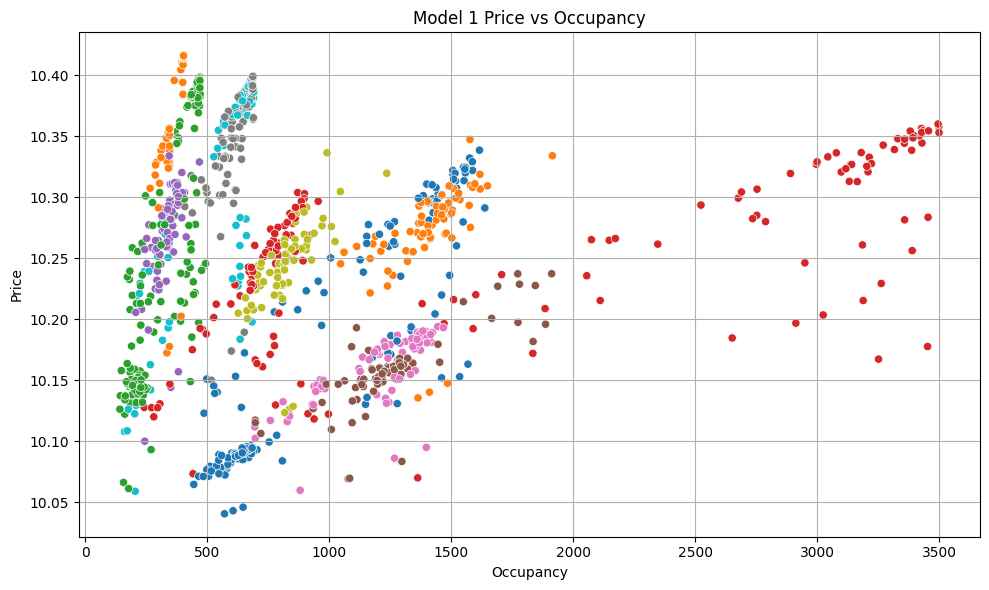

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

df_m1 = pw.debug.table_to_pandas(model1_window)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_m1, x='occupancy', y='linear_price', hue='SystemCodeNumber', palette='tab10', legend=False)
plt.title("Model 1 Price vs Occupancy")
plt.xlabel("Occupancy")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

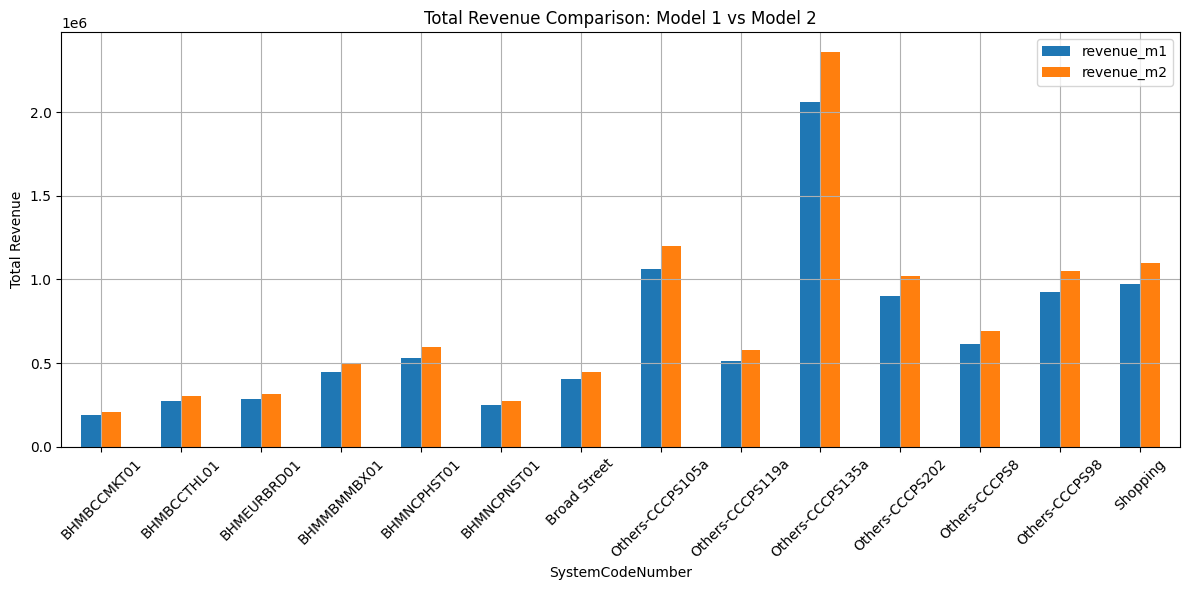

In [132]:
df_m2 = pw.debug.table_to_pandas(model2_window)

# Combine both models
df_m1 = df_m1.rename(columns={"linear_price": "price_m1"})
df_m2 = df_m2.rename(columns={"price": "price_m2"})
revenue_df = pd.merge(df_m1, df_m2, on=["SystemCodeNumber", "t", "occupancy", "capacity"], how="inner")

# Compute revenue
revenue_df["revenue_m1"] = revenue_df["price_m1"] * revenue_df["occupancy"]
revenue_df["revenue_m2"] = revenue_df["price_m2"] * revenue_df["occupancy"]

# Aggregate
revenue_summary = revenue_df.groupby("SystemCodeNumber")[["revenue_m1", "revenue_m2"]].sum().reset_index()

# Plot
revenue_summary.plot(kind='bar', x='SystemCodeNumber', figsize=(12, 6))
plt.title("Total Revenue Comparison: Model 1 vs Model 2")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

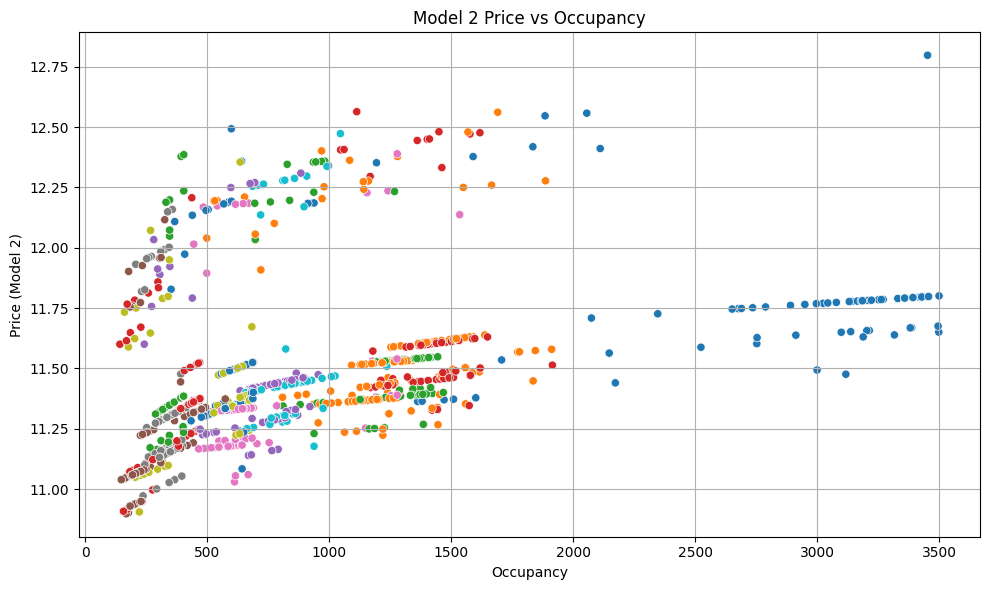

In [135]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_m2,
    x='occupancy',
    y='price_m2',  # Corrected column name
    hue='SystemCodeNumber',
    palette='tab10',
    legend=False
)
plt.title("Model 2 Price vs Occupancy")
plt.xlabel("Occupancy")
plt.ylabel("Price (Model 2)")
plt.grid(True)
plt.tight_layout()
plt.show()

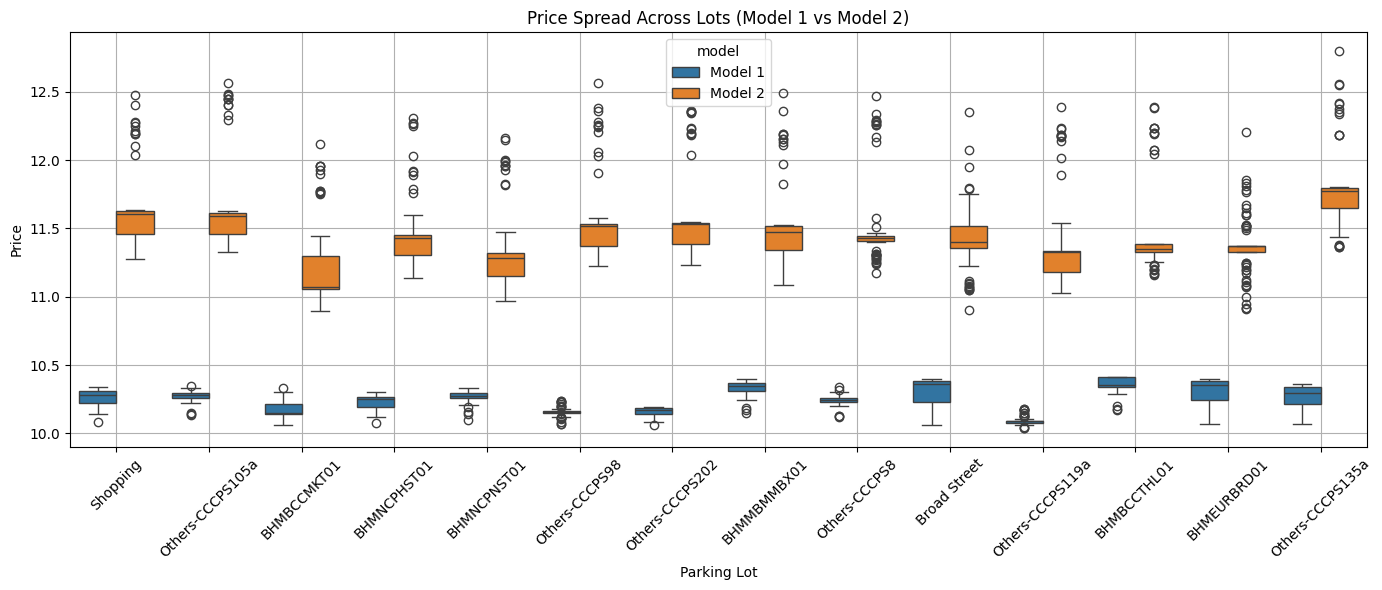

In [138]:
combined_prices = pd.concat([
    df_m1[["SystemCodeNumber", "price_m1"]].assign(model="Model 1", price=df_m1["price_m1"]),
    df_m2[["SystemCodeNumber", "price_m2"]].assign(model="Model 2", price=df_m2["price_m2"])
])

plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_prices, x="SystemCodeNumber", y="price", hue="model")
plt.title("Price Spread Across Lots (Model 1 vs Model 2)")
plt.xlabel("Parking Lot")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Competitive Pricing Model - Model 3

In [262]:
from geopy.distance import great_circle

# 1. Convert model2_window (Pathway output) to a pandas DataFrame
df_model2 = pw.debug.table_to_pandas(model2_window)

# 2. Extract static parking lot location info
location_df = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates()

# 3. Merge location info into Model 2 output
df_model2 = df_model2.merge(location_df, on='SystemCodeNumber', how='left')

# 4. Preprocess timestamps and dates
df_model2['t'] = pd.to_datetime(df_model2['t'])
df_model2['date'] = df_model2['t'].dt.date

# 5. Unique sorted dates and previous date map
available_dates = sorted(df_model2['date'].unique())
prev_date_map = {
    current: max([d for d in available_dates if d < current], default=None)
    for current in available_dates
}

# 6. Define function to find nearby competitors within a given radius
def find_nearby_competitors(system_code, lat, lon, all_locs, radius_km=1.0):
    competitors = []
    for other_code, row in all_locs.iterrows():
        if other_code == system_code:
            continue
        dist = great_circle((lat, lon), (row['Latitude'], row['Longitude'])).km
        if dist <= radius_km:
            competitors.append(other_code)
    return competitors

# 7. Build location lookup index for fast access
loc_data = location_df.set_index('SystemCodeNumber')

# 8. Initialize lists for competitor-based features
avg_comp_prices = []
cheaper_counts = []
min_comp_prices = []
max_comp_prices = []

# 9. For each parking lot, compute competitor statistics
for idx, row in df_model2.iterrows():
    lot_id = row['SystemCodeNumber']
    lat = row['Latitude']
    lon = row['Longitude']
    current_date = row['date']
    competitors = find_nearby_competitors(lot_id, lat, lon, loc_data, radius_km=1.0)

    prev_date = prev_date_map.get(current_date)

    if prev_date:
        competitor_prices = df_model2[
            (df_model2['SystemCodeNumber'].isin(competitors)) &
            (df_model2['date'] == prev_date)
        ]['price']
    else:
        competitor_prices = pd.Series(dtype=float)

    # Fallback: use same-day competitor prices if no previous data
    if competitor_prices.empty:
        competitor_prices = df_model2[
            (df_model2['SystemCodeNumber'].isin(competitors)) &
            (df_model2['date'] == current_date)
        ]['price']
    avg_price = competitor_prices.mean() if not competitor_prices.empty else np.nan
    cheaper_count = (competitor_prices < row['price']).sum() if not competitor_prices.empty else 0
    min_price = competitor_prices.min() if not competitor_prices.empty else np.nan
    max_price = competitor_prices.max() if not competitor_prices.empty else np.nan

    avg_comp_prices.append(avg_price)
    cheaper_counts.append(cheaper_count)
    min_comp_prices.append(min_price)
    max_comp_prices.append(max_price)

# 10. Add new columns to DataFrame
df_model2['Avg_Competitor_Price'] = avg_comp_prices
df_model2['Cheaper_Competitor_Count'] = cheaper_counts
df_model2['Min_Competitor_Price'] = min_comp_prices
df_model2['Max_Competitor_Price'] = max_comp_prices

# 11. Define the Model 3 price adjustment function
def adjust_price(row):
    price = row['price']
    occ_ratio = row['occupancy'] / row['capacity'] if row['capacity'] > 0 else 0
    norm_demand = row.get('norm_demand', None)

    min_comp = row['Min_Competitor_Price']
    max_comp = row['Max_Competitor_Price']
    avg_comp = row['Avg_Competitor_Price']

    # If competitor data is missing → fallback to original price
    if pd.isna(min_comp) or pd.isna(max_comp) or pd.isna(avg_comp):
        return price

    # Neutral zone logic: skip adjustment if price is already close to competitors
    neutral_band = 0.5
    price_gap = price - avg_comp
    if abs(price_gap) < neutral_band:
        return price

    # Business rules
    price_floor = 10   # Minimum reasonable price
    price_cap   = 20   # Maximum cap to prevent overpricing

    # 1. If lot is FULL (or almost full)
    if occ_ratio >= 0.95:
        if price > min_comp + 1:
            return max(price * 0.95, min_comp)
        elif avg_comp - price > 1:
            return min(price * 1.10, avg_comp + 1)
        else:
            return price

    # 2. If lot has moderate demand
    elif 0.5 <= occ_ratio < 0.95:
        if price < avg_comp - 1:
            return min(price * 1.05, avg_comp)
        elif price > max_comp + 1:
            return max(price * 0.95, avg_comp)
        else:
            return price

    # 3. Low demand scenario
    else:
        if norm_demand is not None and norm_demand < 0.3:
            return max(price * 0.95, min_comp)
        elif price > avg_comp + 1:
            return max(price * 0.95, avg_comp)
        else:
            return price

    # 4. Final safeguard
    return min(max(price, price_floor), price_cap)

# 12. Apply the adjustment function
df_model2['Adjusted_Price'] = df_model2.apply(adjust_price, axis=1)

Summary of What This Logic Does:

Scenario	Action

Lot full + you’re too expensive	- Slight price cut

Lot full + you’re underpriced	Raise - price toward competition

Lot not full + you’re cheapest - Increase price a bit

Lot not full + you’re overpriced	- Reduce price toward average

Very low demand (elastic)	- Avoid price hikes, gently decrease

Always	Keep within floor ₹10 and cap ₹20

In [253]:
radius_km = 1.0

competitor_dict = {}

for system_code, row in loc_data.iterrows():
    competitors = find_nearby_competitors(system_code, row['Latitude'], row['Longitude'], loc_data, radius_km=radius_km)
    competitor_dict[system_code] = competitors

# Check competitors now
for lot, comps in competitor_dict.items():
    print(f"Parking lot {lot} competitors within {radius_km} km: {comps}")

Parking lot BHMBCCMKT01 competitors within 1.0 km: ['BHMNCPHST01', 'BHMNCPNST01', 'Shopping', 'BHMEURBRD01', 'Broad Street', 'Others-CCCPS8', 'Others-CCCPS105a', 'Others-CCCPS119a', 'BHMBCCTHL01', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS98']
Parking lot BHMNCPHST01 competitors within 1.0 km: ['BHMBCCMKT01', 'BHMNCPNST01', 'Others-CCCPS8', 'Others-CCCPS105a', 'Others-CCCPS119a', 'BHMBCCTHL01', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS98']
Parking lot BHMMBMMBX01 competitors within 1.0 km: []
Parking lot BHMNCPNST01 competitors within 1.0 km: ['BHMBCCMKT01', 'BHMNCPHST01', 'Others-CCCPS8', 'Others-CCCPS105a', 'Others-CCCPS119a', 'BHMBCCTHL01', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS98']
Parking lot Shopping competitors within 1.0 km: ['BHMBCCMKT01', 'BHMEURBRD01', 'Others-CCCPS8', 'Others-CCCPS105a', 'Others-CCCPS119a', 'BHMBCCTHL01', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS98']
Parking lot BHMEURBRD01 competitors within 1.0 km: ['BHMBCCMKT

In [254]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Category20
output_notebook()

def plot_model3(df):
    required_cols = {'t', 'SystemCodeNumber', 'Adjusted_Price'}
    if not required_cols.issubset(df.columns):
        return  # silently skip if required columns not present

    df = df.copy()
    df['t'] = pd.to_datetime(df['t'])

    fig = figure(
        height=400, width=800,
        title="Model 3: Adjusted Prices Over Time",
        x_axis_type="datetime",
        x_axis_label="Date",
        y_axis_label="Adjusted Price (₹)",
        toolbar_location=None
    )

    lot_ids = df['SystemCodeNumber'].unique()
    colors = Category20[20] if len(lot_ids) <= 20 else [f"#{i:06x}" for i in range(len(lot_ids))]

    for i, lot_id in enumerate(lot_ids):
        lot_df = df[df['SystemCodeNumber'] == lot_id].sort_values('t')
        fig.line(
            x=lot_df['t'],
            y=lot_df['Adjusted_Price'],
            line_width=2,
            color=colors[i % len(colors)],
            legend_label=str(lot_id)
        )

    fig.legend.click_policy = "hide"
    fig.legend.label_text_font_size = '10pt'
    fig.title.text_font_size = '14pt'
    fig.xaxis.major_label_orientation = 0.5
    show(fig)

In [265]:
plot_model3(df_model2)

In [266]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column
import pandas as pd

output_notebook()

# Convert Pathway tables to DataFrames
df_model1 = pw.debug.table_to_pandas(model1_window)
df_model2_base = pw.debug.table_to_pandas(model2_window)  # base Model 2 (without adjustment)

# Merge all models by SystemCodeNumber and timestamp
merged = df_model1[['SystemCodeNumber', 't', 'linear_price']].merge(
    df_model2_base[['SystemCodeNumber', 't', 'price']],
    on=['SystemCodeNumber', 't'], how='inner'
).merge(
    df_model2[['SystemCodeNumber', 't', 'Adjusted_Price']],
    on=['SystemCodeNumber', 't'], how='inner'
)

# Get unique parking lots
parking_lots = merged['SystemCodeNumber'].unique()

# Sort by timestamp just in case
merged = merged.sort_values(['SystemCodeNumber', 't'])

# Plot each lot separately
plots = []

for lot in parking_lots:
    lot_df = merged[merged['SystemCodeNumber'] == lot]

    fig = figure(
        height=300, width=800,
        title=f"Price Comparison for {lot}",
        x_axis_type="datetime",
        x_axis_label="Timestamp",
        y_axis_label="Price (₹)"
    )

    fig.line(lot_df['t'], lot_df['linear_price'], color="blue", legend_label="Model 1: Linear", line_width=2)
    fig.line(lot_df['t'], lot_df['price'], color="orange", legend_label="Model 2: Demand-Based", line_width=2)
    fig.line(lot_df['t'], lot_df['Adjusted_Price'], color="green", legend_label="Model 3: Competitive", line_width=2)

    fig.legend.click_policy = "hide"
    plots.append(fig)

# Display all plots in a vertical layout (14 total)
show(column(*plots))

In [280]:
comp_count = (df_model2['Adjusted_Price'] < df_model2['Min_Competitor_Price']).sum()
total_count = df_model2.shape[0]

print(f"Model 3 undercut competitors in {100 * comp_count / total_count:.1f}% of cases")

Model 3 undercut competitors in 14.8% of cases


In [263]:
revenue_model2 = (df_model2['price'] * df_model2['occupancy']).sum()
revenue_model3 = (df_model2['Adjusted_Price'] * df_model2['occupancy']).sum()

print(f" Total Revenue — Model 2 (Demand-Based Pricing Logic): ₹{revenue_model2:,.0f}")
print(f" Total Revenue — Model 3 (Competitive Pricing Model): ₹{revenue_model3:,.0f}")

 Total Revenue — Model 2 (Demand-Based Pricing Logic): ₹10,650,048
 Total Revenue — Model 3 (Competitive Pricing Model): ₹10,649,467


In [264]:
undercut_cases = (df_model2['Adjusted_Price'] < df_model2['Avg_Competitor_Price']).sum()
overpriced_cases = (df_model2['Adjusted_Price'] > df_model2['Avg_Competitor_Price']).sum()
total_cases = df_model2['Adjusted_Price'].notna().sum()

print(f"🔻 Undercut competitors in: {100 * undercut_cases / total_cases:.1f}% of cases")
print(f"🔺 Overpriced vs competitors in: {100 * overpriced_cases / total_cases:.1f}% of cases")

🔻 Undercut competitors in: 45.6% of cases
🔺 Overpriced vs competitors in: 47.3% of cases


In [267]:
volatility_model2 = df_model2.groupby('SystemCodeNumber')['price'].std().mean()
volatility_model3 = df_model2.groupby('SystemCodeNumber')['Adjusted_Price'].std().mean()

print(f"📉 Avg Price Volatility — Model 2: ₹{volatility_model2:.2f}")
print(f"📉 Avg Price Volatility — Model 3: ₹{volatility_model3:.2f}")

📉 Avg Price Volatility — Model 2: ₹0.29
📉 Avg Price Volatility — Model 3: ₹0.28


In [268]:
eff_model2 = (df_model2['price'] * df_model2['occupancy']).sum() / df_model2['occupancy'].sum()
eff_model3 = (df_model2['Adjusted_Price'] * df_model2['occupancy']).sum() / df_model2['occupancy'].sum()

print(f"📊 Avg Revenue per Occupied Slot — Model 2: ₹{eff_model2:.2f}")
print(f"📊 Avg Revenue per Occupied Slot — Model 3: ₹{eff_model3:.2f}")

📊 Avg Revenue per Occupied Slot — Model 2: ₹11.58
📊 Avg Revenue per Occupied Slot — Model 3: ₹11.58


In [269]:
high_demand = df_model2['occupancy'] / df_model2['capacity'] > 0.9
smart_pricing = df_model2['Adjusted_Price'] > df_model2['Avg_Competitor_Price']
win_cases = (high_demand & smart_pricing).sum()

print(f"🔥 Smart price hikes during high demand: {win_cases} cases")

🔥 Smart price hikes during high demand: 74 cases


In [270]:
daily_rev_2 = df_model2.groupby('date').apply(lambda x: (x['price'] * x['occupancy']).sum())
daily_rev_3 = df_model2.groupby('date').apply(lambda x: (x['Adjusted_Price'] * x['occupancy']).sum())

print(f"📆 Avg Daily Revenue — Model 2: ₹{daily_rev_2.mean():.0f}")
print(f"📆 Avg Daily Revenue — Model 3: ₹{daily_rev_3.mean():.0f}")

📆 Avg Daily Revenue — Model 2: ₹145891
📆 Avg Daily Revenue — Model 3: ₹145883


/tmp/ipython-input-270-1304296297.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_rev_2 = df_model2.groupby('date').apply(lambda x: (x['price'] * x['occupancy']).sum())
/tmp/ipython-input-270-1304296297.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_rev_3 = df_model2.groupby('date').apply(lambda x: (x['Adjusted_Price'] * x['occupancy']).sum())


In [274]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Category10
from bokeh.models import HoverTool

output_notebook()

# 🔍 Filter for smart price hike cases
smart_df = df_model2[
    (df_model2['occupancy'] / df_model2['capacity'] >= 0.90) &
    (df_model2['Adjusted_Price'] > df_model2['Avg_Competitor_Price'])
].copy()

smart_df['t'] = pd.to_datetime(smart_df['t'])

# 🎨 Setup Bokeh figure
p = figure(
    title="🔥 Smart Price Hikes — High Demand + Higher than Competitors",
    x_axis_type="datetime",
    width=850,
    height=400,
    x_axis_label="Date",
    y_axis_label="Adjusted Price (₹)"
)

# 🟢 Plot each lot
lot_ids = smart_df['SystemCodeNumber'].unique()
colors = Category10[10] if len(lot_ids) <= 10 else ["gray"] * len(lot_ids)

for i, lot_id in enumerate(lot_ids):
    lot_data = smart_df[smart_df['SystemCodeNumber'] == lot_id]
    p.circle(
        x=lot_data['t'],
        y=lot_data['Adjusted_Price'],
        size=8,
        color=colors[i % len(colors)],
        legend_label=str(lot_id)
    )

# 🛠️ Add hover tool
hover = HoverTool(tooltips=[
    ("Date", "@x{%F}"),
    ("Lot", "@legend_label"),
    ("Adj Price", "@y{0.00}"),
], formatters={'@x': 'datetime'})

p.add_tools(hover)
p.legend.click_policy = "hide"

show(p)